In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [6]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [7]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 22

In [14]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [9]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [10]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [11]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [12]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

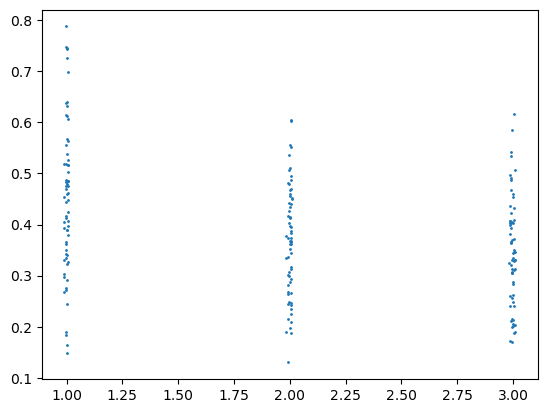

In [13]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [15]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [16]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(194, 3)


In [17]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [18]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [19]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.03it/s]


Loss: 2603.094835370779
Average Loss: 0.35619797966212086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.16it/s]


Loss: 1547.156068868935
Average Loss: 0.2117071796481849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.51it/s]


Loss: 430.9073849688284
Average Loss: 0.058963791046637716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.66it/s]


Loss: 427.11741605447605
Average Loss: 0.0584451855575364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.00it/s]


Loss: 425.2870562924072
Average Loss: 0.058194725819979094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.47it/s]


Loss: 424.74635545234196
Average Loss: 0.05812073829397126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.52it/s]


Loss: 423.71602076105773
Average Loss: 0.057979751061994766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.87it/s]


Loss: 423.9508130552713
Average Loss: 0.058011879181071604
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.64it/s]


Loss: 423.6980923076626
Average Loss: 0.057977297797983385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.14it/s]


Loss: 423.0171075775288
Average Loss: 0.05788411433737395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▊                                                                                                                                                           | 129/7308 [00:03<00:58, 122.93it/s]

X_batch: 
torch.Size([128, 194])
tensor([[0.3390, 0.1514, 0.1480,  ..., 0.4767, 0.1324, 0.2490],
        [0.3358, 0.2689, 0.1497,  ..., 0.4172, 0.1771, 0.2487],
        [0.4657, 0.4293, 0.1809,  ..., 0.4307, 0.1929, 0.3860],
        ...,
        [0.5578, 0.2322, 0.1367,  ..., 0.4761, 0.2355, 0.2504],
        [0.6233, 0.3731, 0.1652,  ..., 0.5024, 0.1899, 0.3223],
        [0.3186, 0.8764, 0.8141,  ..., 0.6676, 0.5261, 0.2569]])
X_pred: 
torch.Size([128, 194])
tensor([[0.4237, 0.2118, 0.1280,  ..., 0.4217, 0.1272, 0.2161],
        [0.4741, 0.2607, 0.1655,  ..., 0.4710, 0.1656, 0.2660],
        [0.4743, 0.3095, 0.2228,  ..., 0.4604, 0.2379, 0.3086],
        ...,
        [0.5349, 0.3048, 0.1822,  ..., 0.5303, 0.1848, 0.3063],
        [0.5522, 0.3156, 0.1835,  ..., 0.5484, 0.1855, 0.3153],
        [0.8161, 0.7358, 0.6155,  ..., 0.7820, 0.6517, 0.7450]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.84it/s]


Loss: 422.5578037011437
Average Loss: 0.057821264874267066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.64it/s]


Loss: 422.6365372436121
Average Loss: 0.05783203848434758
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.08it/s]


Loss: 422.6362109524198
Average Loss: 0.05783199383585383
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.16it/s]


Loss: 422.15438690502197
Average Loss: 0.057766062794885324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.71it/s]


Loss: 421.9809976108372
Average Loss: 0.05774233683782666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.05it/s]


Loss: 421.78026852337644
Average Loss: 0.05771486980341768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.00it/s]


Loss: 421.31295410264283
Average Loss: 0.05765092420671084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.44it/s]


Loss: 421.48470051703043
Average Loss: 0.057674425358104874
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.22it/s]


Loss: 421.0835105404258
Average Loss: 0.05761952798856401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.56it/s]


Loss: 420.8526174959261
Average Loss: 0.05758793342856132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.91it/s]


Loss: 420.85389428935014
Average Loss: 0.05758810814030516
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.03it/s]


Loss: 420.73778631235473
Average Loss: 0.05757222034925489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.11it/s]


Loss: 420.71496536326595
Average Loss: 0.05756909761402106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.51it/s]


Loss: 420.3481541448273
Average Loss: 0.05751890450804971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.85it/s]


Loss: 420.2694997738581
Average Loss: 0.05750814173150768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.73it/s]


Loss: 420.198472446762
Average Loss: 0.05749842261176273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.82it/s]


Loss: 419.48405572003685
Average Loss: 0.05740066443897603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.91it/s]


Loss: 419.5982233574614
Average Loss: 0.05741628672105383
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.96it/s]


Loss: 419.42688178503886
Average Loss: 0.05739284096675409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.25it/s]


Loss: 418.4069552656729
Average Loss: 0.057253277950967824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.36it/s]


Loss: 417.4680426500272
Average Loss: 0.05712480058155818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.50it/s]


Loss: 416.97314152447507
Average Loss: 0.057057080121028336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.92it/s]


Loss: 416.5681088322308
Average Loss: 0.057001656928329335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 98.98it/s]


Loss: 415.8689388083294
Average Loss: 0.05690598505861103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.34it/s]


Loss: 416.29952799505554
Average Loss: 0.05696490530857355
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.74it/s]


Loss: 415.4590971376747
Average Loss: 0.05684990382288926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.60it/s]


Loss: 415.502478931332
Average Loss: 0.0568558400289179
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.04it/s]


Loss: 414.89921259949915
Average Loss: 0.056773291269772735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.02it/s]


Loss: 414.97705622343346
Average Loss: 0.05678394310665483
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.20it/s]


Loss: 414.50179079920053
Average Loss: 0.05671890952370013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.77it/s]


Loss: 414.30576639901847
Average Loss: 0.05669208626149678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.33it/s]


Loss: 413.87750305607915
Average Loss: 0.05663348427149414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.46it/s]


Loss: 413.6994421109557
Average Loss: 0.05660911906280182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.92it/s]


Loss: 412.75000710529275
Average Loss: 0.05647920184801488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.55it/s]


Loss: 412.56034792982973
Average Loss: 0.05645324957988913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.81it/s]


Loss: 412.5687306735199
Average Loss: 0.056454396643886136
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.25it/s]


Loss: 412.1703481769655
Average Loss: 0.05639988343965045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.44it/s]


Loss: 412.0895157593768
Average Loss: 0.05638882262717253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.39it/s]


Loss: 411.48267777916044
Average Loss: 0.056305785136721465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 137.93it/s]


Loss: 411.2883643049281
Average Loss: 0.05627919599136947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.40it/s]


Loss: 411.22417037934065
Average Loss: 0.056270411929302225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.87it/s]


Loss: 410.82128955447115
Average Loss: 0.05621528319026699
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.85it/s]


Loss: 410.88771436410025
Average Loss: 0.05622437251834979
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.38it/s]


Loss: 410.77230591047555
Average Loss: 0.05620858044751992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.11it/s]


Loss: 410.7603274509311
Average Loss: 0.0562069413589123
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.87it/s]


Loss: 410.3109069908969
Average Loss: 0.056145444306362466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.38it/s]


Loss: 410.16808713879436
Average Loss: 0.05612590135998828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.21it/s]


Loss: 410.26203180197626
Average Loss: 0.05613875640421131
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.75it/s]


Loss: 409.84521753620356
Average Loss: 0.056081721064067266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.99it/s]


Loss: 409.81854182085954
Average Loss: 0.056078070856713125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.18it/s]


Loss: 409.48685142444447
Average Loss: 0.05603268355561637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.76it/s]


Loss: 409.55647967010736
Average Loss: 0.056042211230173423
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.80it/s]


Loss: 409.0685313323047
Average Loss: 0.05597544216369796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.54it/s]


Loss: 409.33413908979855
Average Loss: 0.056011786958100516
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.75it/s]


Loss: 409.2297208122909
Average Loss: 0.05599749874278748
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.61it/s]


Loss: 409.17412885138765
Average Loss: 0.055989891742116535
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.95it/s]


Loss: 408.9347095871344
Average Loss: 0.055957130485376906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.18it/s]


Loss: 408.95703699672595
Average Loss: 0.05596018568647044
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.20it/s]


Loss: 408.8708747017663
Average Loss: 0.05594839555306052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.30it/s]


Loss: 408.6240227634553
Average Loss: 0.055914617236378666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.82it/s]


Loss: 409.13510378682986
Average Loss: 0.05598455169496851
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.20it/s]


Loss: 408.6572701635305
Average Loss: 0.05591916668904358
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.34it/s]


Loss: 408.6700924714096
Average Loss: 0.055920921246771976
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.83it/s]


Loss: 408.67136922688223
Average Loss: 0.055921095953322696
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.35it/s]


Loss: 408.27390307956375
Average Loss: 0.05586670813896603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.67it/s]


Loss: 408.51240509119816
Average Loss: 0.055899343882211024
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.93it/s]


Loss: 408.28877999121323
Average Loss: 0.05586874384116218
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.00it/s]


Loss: 408.38834942830727
Average Loss: 0.05588236855888167
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.81it/s]


Loss: 408.11547710420564
Average Loss: 0.05584502970774571
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.01it/s]


Loss: 408.10413108044304
Average Loss: 0.05584347715933813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.92it/s]


Loss: 408.3449536792468
Average Loss: 0.055876430443246694
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.03it/s]


Loss: 408.0589269970078
Average Loss: 0.05583729159783905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.51it/s]


Loss: 408.2388050511945
Average Loss: 0.05586190545309175
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.95it/s]


Loss: 408.08815507241525
Average Loss: 0.055841291060812155
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.14it/s]


Loss: 407.9094538690988
Average Loss: 0.055816838241529665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.90it/s]


Loss: 407.8413083453197
Average Loss: 0.05580751345721397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.88it/s]


Loss: 407.7641365034506
Average Loss: 0.05579695354453346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.76it/s]


Loss: 408.0578615809791
Average Loss: 0.05583714581020513
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.03it/s]


Loss: 407.83848961559124
Average Loss: 0.055807127752543956
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.24it/s]


Loss: 407.5907772912178
Average Loss: 0.055773231703779125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.68it/s]


Loss: 407.7043753853068
Average Loss: 0.05578877605162928
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.25it/s]


Loss: 407.63742169411853
Average Loss: 0.05577961435332766
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.51it/s]


Loss: 407.47012187051587
Average Loss: 0.05575672165715871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.22it/s]


Loss: 407.457940653665
Average Loss: 0.055755054823982624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.93it/s]


Loss: 407.4198279893026
Average Loss: 0.05574983962634135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.75it/s]


Loss: 407.35364443436265
Average Loss: 0.055740783310668125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.98it/s]


Loss: 407.39852542756125
Average Loss: 0.05574692466168052
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.58it/s]


Loss: 407.4172816320788
Average Loss: 0.05574949119212901
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.04it/s]


Loss: 407.4043580174912
Average Loss: 0.05574772277196102
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.97it/s]


Loss: 407.2698459189851
Average Loss: 0.055729316628213614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.99it/s]


Loss: 407.42093634954654
Average Loss: 0.05574999129030467
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.11it/s]


Loss: 407.34189118701033
Average Loss: 0.05573917503927345
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.45it/s]


Loss: 407.0558073420543
Average Loss: 0.05570002837192862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.82it/s]


Loss: 407.2560899667442
Average Loss: 0.055727434314004405
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.71it/s]


Loss: 407.2827921791468
Average Loss: 0.055731088147119155
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.98it/s]


Loss: 407.0988531156909
Average Loss: 0.05570591859820619
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.31it/s]


Loss: 407.07803351199254
Average Loss: 0.05570306971975815
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.28it/s]


Loss: 407.0461222685408
Average Loss: 0.055698703101880236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.27it/s]


Loss: 407.16828988306224
Average Loss: 0.05571542007157392
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.54it/s]


Loss: 406.73427746864036
Average Loss: 0.055656031399649745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.76it/s]


Loss: 406.91841108957306
Average Loss: 0.055681227571096475
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.31it/s]


Loss: 407.03065442782827
Average Loss: 0.05569658653911169
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.85it/s]


Loss: 406.8585075852461
Average Loss: 0.05567303059458759
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.94it/s]


Loss: 407.0474351493176
Average Loss: 0.0556988827516855
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.02it/s]


Loss: 406.76590213994496
Average Loss: 0.055660358804042825
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.69it/s]


Loss: 406.6964141142089
Average Loss: 0.05565085031666788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.59it/s]


Loss: 406.7033717583399
Average Loss: 0.05565180237525177
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.38it/s]


Loss: 406.91097916662693
Average Loss: 0.05568021061393363
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.12it/s]


Loss: 406.80383033980615
Average Loss: 0.0556655487602362
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.96it/s]


Loss: 406.65466895210557
Average Loss: 0.05564513806131713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.10it/s]


Loss: 406.81026322743855
Average Loss: 0.05566642901305946
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.82it/s]


Loss: 406.75773785007186
Average Loss: 0.05565924163246742
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.40it/s]


Loss: 406.59839395433664
Average Loss: 0.055637437596378854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.52it/s]


Loss: 406.513062762795
Average Loss: 0.055625761188121924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 114.04it/s]


Loss: 406.54095848975703
Average Loss: 0.05562957833740518
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.44it/s]


Loss: 406.7355639943853
Average Loss: 0.055656207443128804
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.94it/s]


Loss: 406.57972726156004
Average Loss: 0.05563488331438971
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.56it/s]


Loss: 406.6632415028289
Average Loss: 0.05564631109781457
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.32it/s]


Loss: 406.5152172455564
Average Loss: 0.05562605599966563
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.09it/s]


Loss: 406.5892892628908
Average Loss: 0.05563619174369059
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.57it/s]


Loss: 406.3047129998449
Average Loss: 0.05559725136834222
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.14it/s]


Loss: 406.660361189628
Average Loss: 0.05564591696628736
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.26it/s]


Loss: 406.5354866888374
Average Loss: 0.0556288295961737
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.69it/s]


Loss: 406.4829877356533
Average Loss: 0.055621645831370185
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.94it/s]


Loss: 406.32672981731594
Average Loss: 0.05560026406914559
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.76it/s]


Loss: 406.5713002383709
Average Loss: 0.05563373019134796
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.15it/s]


Loss: 406.48627854534425
Average Loss: 0.05562209613373621
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.55it/s]


Loss: 406.43796189059503
Average Loss: 0.05561548465935893
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.85it/s]


Loss: 406.50463983719237
Average Loss: 0.05562460862577892
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.37it/s]


Loss: 406.28592437901534
Average Loss: 0.055594680402164115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.28it/s]


Loss: 406.35068353335373
Average Loss: 0.055603541808067015
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.14it/s]


Loss: 406.44638542621396
Average Loss: 0.05561663730517433
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.83it/s]


Loss: 406.2835627878085
Average Loss: 0.05559435725065798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.84it/s]


Loss: 406.48708208301105
Average Loss: 0.05562220608689259
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.40it/s]


Loss: 406.0964525497984
Average Loss: 0.055568753769813684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.36it/s]


Loss: 406.3378644878976
Average Loss: 0.05560178769675665
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.50it/s]


Loss: 406.11688911239617
Average Loss: 0.05557155023431803
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.85it/s]


Loss: 406.3328131660819
Average Loss: 0.05560109649234837
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.31it/s]


Loss: 406.12205917714164
Average Loss: 0.05557225768707466
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.31it/s]


Loss: 406.33172435010783
Average Loss: 0.055600947502751484
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.33it/s]


Loss: 406.13206786708906
Average Loss: 0.05557362723961262
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.13it/s]


Loss: 406.1361340365838
Average Loss: 0.055574183639379285
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.30it/s]


Loss: 406.17492054146715
Average Loss: 0.0555794910428937
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.19it/s]


Loss: 406.137121231528
Average Loss: 0.055574318723526
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.78it/s]


Loss: 406.0112380303908
Average Loss: 0.055557093326544994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.61it/s]


Loss: 406.24529993114993
Average Loss: 0.055589121501252045
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.66it/s]


Loss: 406.0325488226954
Average Loss: 0.055560009417446
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.42it/s]


Loss: 405.96694003790617
Average Loss: 0.055551031751218685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.42it/s]


Loss: 406.01015289197676
Average Loss: 0.05555694484017197
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.25it/s]


Loss: 406.16458516428247
Average Loss: 0.05557807678766865
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.34it/s]


Loss: 406.1356424901169
Average Loss: 0.05557411637795798
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.32it/s]


Loss: 406.32454809895717
Average Loss: 0.055599965530782315
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.96it/s]


Loss: 405.9275579021778
Average Loss: 0.05554564284375722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.72it/s]


Loss: 406.10829786304384
Average Loss: 0.055570374639168564
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.40it/s]


Loss: 406.0343327196315
Average Loss: 0.055560253519380334
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.76it/s]


Loss: 405.94259085087106
Average Loss: 0.055547699897491934
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.95it/s]


Loss: 405.9542874696199
Average Loss: 0.055549300420035565
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 146.08it/s]


Loss: 405.9633135169279
Average Loss: 0.055550535511347546
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.67it/s]


Loss: 406.2261176966131
Average Loss: 0.05558649667441339
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.67it/s]


Loss: 405.91369668836705
Average Loss: 0.05554374612593966
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.21it/s]


Loss: 405.9223124005366
Average Loss: 0.0555449250684916
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.55it/s]


Loss: 405.88897026726045
Average Loss: 0.055540362652881835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.32it/s]


Loss: 406.0565184354782
Average Loss: 0.0555632893316199
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.83it/s]


Loss: 405.9817863421049
Average Loss: 0.055553063265203186
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.16it/s]


Loss: 405.79688169201836
Average Loss: 0.05552776158894614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.63it/s]


Loss: 405.9341693788301
Average Loss: 0.055546547534049
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.72it/s]


Loss: 406.02807716373354
Average Loss: 0.055559397531983246
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.07it/s]


Loss: 405.8402548257727
Average Loss: 0.05553369660998532
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.81it/s]


Loss: 405.7832552990876
Average Loss: 0.05552589700315923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.11it/s]


Loss: 405.7444992279634
Average Loss: 0.05552059376408913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.66it/s]


Loss: 405.7931339959614
Average Loss: 0.05552724876792028
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.28it/s]


Loss: 405.8867452275008
Average Loss: 0.055540058186576466
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.37it/s]


Loss: 405.6923384014517
Average Loss: 0.05551345626730319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.05it/s]


Loss: 405.61612171679735
Average Loss: 0.05550302705484365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.56it/s]


Loss: 405.7533734519966
Average Loss: 0.055521808080459305
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.33it/s]


Loss: 405.8560032050591
Average Loss: 0.055535851560626584
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.89it/s]


Loss: 405.7568632736802
Average Loss: 0.05552228561489877
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.85it/s]


Loss: 405.62600913411006
Average Loss: 0.05550438001287768
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.74it/s]


Loss: 405.70321503910236
Average Loss: 0.055514944586631414
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.90it/s]


Loss: 405.6761389290914
Average Loss: 0.055511239590735
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.53it/s]


Loss: 405.7631843406707
Average Loss: 0.05552315056659424
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.51it/s]


Loss: 405.8102652844973
Average Loss: 0.055529592950806964
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.95it/s]


Loss: 405.70551926339976
Average Loss: 0.05551525988825941
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.87it/s]

Loss: 405.7609458649531
Average Loss: 0.05552284426176151
Done, best loss: 405.61612171679735
Done


<All keys matched successfully>

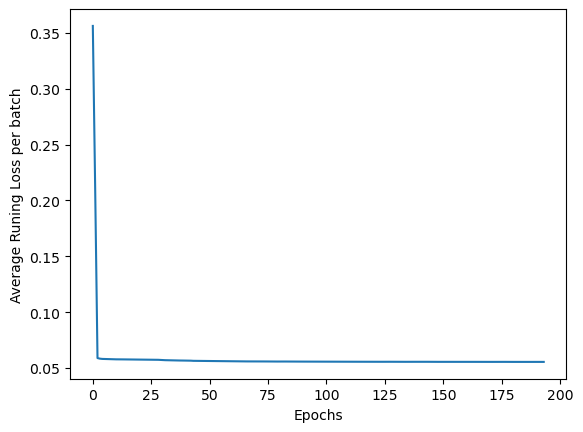

In [20]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [21]:
torch.save(final_model, 'model_100206_13g_06.pt')